In [1]:
!pip install category_encoders
!pip install texthero
!pip install textdistance

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 80 kB 1.0 MB/s 
     |████████████████████████████████| 9.5 MB 4.6 MB/s 
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.4 MB 4.1 MB/s 
     |████████████████████████████████| 366 kB 6.7 MB/s 
     |████████████████████████████████| 6.8 MB 6.8 MB/s 
     |████████████████████████████████| 238 kB 38.8 MB/s 
     |████████████████████████████████| 11.6 MB 21.2 MB/s 
     |████████████████████████████████| 10.4 MB 13.9 MB/s 
     |████████████████████████████████| 24.2 MB 955 kB/s 
     |████████████████████████████████| 82 kB 2.6 MB/s 
     |████████████████████████████████| 723 kB 20.8 MB/s 
     |████████████████████████████████| 1.1 MB 27.8 MB/s 
     |████████████████████████████████| 184 kB 54.6 MB/s 
 

In [1]:
import pandas as pd
import pathlib
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import texthero as hero
from texthero import preprocessing

from sklearn import metrics
from sklearn.model_selection import GroupKFold, KFold

import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.decomposition import PCA
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import model_selection
import os
import random

In [2]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    
seed_everything(0)

In [3]:
DATA_DIR = pathlib.Path('/home/knikaido/work/atma8/data/')
OUTPUT_DIR = './sub31/'
train_csv_path = DATA_DIR / 'train.csv'
test_csv_path = DATA_DIR / 'test.csv'

In [4]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)


In [5]:
# train_df['Pub_Genre'] = train_df['Publisher'] + ' ' + train_df['Genre']
# test_df['Pub_Genre'] = test_df['Publisher'] + ' ' + test_df['Genre']

In [6]:
whole_df = pd.concat([train_df, test_df], ignore_index=True)

In [7]:
def preprocess(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = input_df.copy()

    idx_tbd = input_df['User_Score'] == 'tbd'
    output_df['User_Score_is_tbd'] = idx_tbd.astype(int)

    output_df['User_Score'] = input_df['User_Score'].replace('tbd', None).astype(float)
    return output_df

def create_continuous_features(input_df):
    input_df = preprocess(input_df)
    use_columns = [
        # 連続変数
        'Critic_Score',
        'Critic_Count', 
        'User_Score', 
        'User_Count',
        'Year_of_Release',
        'User_Score_is_tbd'
    ]
    return input_df[use_columns].copy()

In [8]:
def create_boolean_feature(input_df):
    output_df = pd.DataFrame()

    texts = [
        'japan', 'nintendo'
    ]

    for t in texts:
        output_df[f'Developer_has_{t}'] = input_df['Developer'].fillna('').str.lower().str.contains(t).astype(int)
    return output_df

In [9]:
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        raise NotImplementedError()

In [10]:
class CountEncodingBlock(BaseBlock):
    def __init__(self, column, whole_df: pd.DataFrame):
        self.column = column
        self.whole_df = whole_df

    def transform(self, input_df):
        output_df = pd.DataFrame()
        c = self.column

        vc = self.whole_df[c].value_counts()
        output_df[c] = input_df[c].map(vc)
        return output_df.add_prefix('CE_')

In [11]:
class OneHotBlock(BaseBlock):
    def __init__(self, column: str):
        self.column = column
        self.cats_ = None

    def fit(self, input_df, y=None):
        vc = input_df[self.column].dropna().value_counts()
        cats = vc[vc > 40].index
        self.cats_ = cats
        return self.transform(input_df)

    def transform(self, input_df):
        x = pd.Categorical(input_df[self.column], categories=self.cats_)
        out_df = pd.get_dummies(x, dummy_na=False)
        out_df.columns = out_df.columns.tolist()
        return out_df.add_prefix(f'OH_{self.column}=')

In [12]:
from textdistance import jaro
from nltk.util import ngrams

def line_ngram(line, n=2):
    words = [w for w in line.split(' ') if len(w) != 0] # 空文字は取り除く
    return list(ngrams(words, n))

In [13]:
def clearn_by_hero(x):
    custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                   , preprocessing.remove_stopwords
                  ]
    return hero.clean(x, custom_pipeline)

def create_n_gram(x, n=3):
    x = clearn_by_hero(x)
    x = pd.Series(x).map(lambda r: line_ngram(r, n=n))
    return x

class NameNGramBlock(BaseBlock):
    def __init__(self, whole_df, n=3):
        self.whole_df = whole_df
        self.n = n

    def fit(self, input_df, y=None):
        name_grams = create_n_gram(self.whole_df['Name'], n=self.n)
        grams = [x for row in name_grams for x in row if len(x) > 0]
        top_grams = pd.Series(grams).value_counts().head(20).index

        self.top_grams_ = top_grams
        return self.transform(input_df)

    def transform(self, input_df):
        name_grams = create_n_gram(input_df['Name'], n=self.n)
        output_df = pd.DataFrame()

        for top in self.top_grams_:
            s_top = '-'.join(top)
            output_df[f'{s_top}'] = name_grams.map(lambda x: top in x).map(int)
        output_df_ = output_df != 0
        output_df['all'] = output_df_.sum(axis=1) != 0

        return output_df.add_prefix('Name_has_').add_suffix(f'_n={self.n}')

In [14]:
sales_columns = train_df.columns[train_df.columns.str.contains('Sales')].tolist()
sales_columns = sorted(sales_columns)

In [15]:
class SalesPortfolioBlock(BaseBlock):
    """売上ポートフォリオ"""

    def __init__(self, key: str):
        self.key = key    
        self.meta_df = None

    def fit(self, input_df):
#         input_df['Global_oof'] = pd.read_csv(OUTPUT_DIR+'oof25.csv')['Global_Sales']
#         _df = input_df['Global_oof'].groupby(input_df[self.key]).sum()
        _df = input_df[sales_columns].groupby(input_df[self.key]).sum()
        _df = (_df.T / _df.sum(axis=1)).T
        self.meta_df = _df
        return self.transform(input_df)

    def transform(self, input_df):
        out_df = pd.merge(input_df[self.key], self.meta_df, on=self.key, how='left').drop(columns=[self.key])
        out_df = out_df.add_prefix(f'SP@{self.key}_')
        return out_df

In [16]:
class WrapperBlock(BaseBlock):
    def __init__(self, function):
        self.function = function

    def transform(self, input_df):
        return self.function(input_df)

In [17]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [18]:
process_blocks = [
    WrapperBlock(create_continuous_features),
#     WrapperBlock(create_boolean_feature),
    NameNGramBlock(whole_df, n=3),
    *[OneHotBlock(c) for c in ['Platform', 'Genre', 'Rating']],
    *[CountEncodingBlock(c, whole_df=whole_df) for c in ['Name', 'Platform', 'Year_of_Release']],
    *[SalesPortfolioBlock(c) for c in ['Genre', 'Rating',  'Platform']]
]

In [19]:
from tqdm import tqdm


def get_function(block, is_train):
    s = mapping = {
        True: 'fit',
        False: 'transform'
    }.get(is_train)
    return getattr(block, s)


def to_feature(input_df, 
               blocks,
               is_train=False):
    out_df = pd.DataFrame()

    for block in tqdm(blocks, total=len(blocks)):
        func = get_function(block, is_train)

        with timer(prefix='create ' + str(block) + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df


In [20]:
# train_feat_df = to_feature(train_df, process_blocks, is_train=True)
# test_feat_df = to_feature(test_df, process_blocks)
whole_feat_df = to_feature(whole_df, process_blocks, is_train=True)
train_feat_df = whole_feat_df.iloc[:len(train_df), :]
test_feat_df = whole_feat_df.iloc[len(train_df):, :]

  0%|          | 0/11 [00:00<?, ?it/s]

create <__main__.WrapperBlock object at 0x7f40455206a0> 0.006[s]


100%|██████████| 11/11 [00:00<00:00, 19.62it/s]

create <__main__.NameNGramBlock object at 0x7f4045520780> 0.492[s]
create <__main__.OneHotBlock object at 0x7f4045520748> 0.004[s]
create <__main__.OneHotBlock object at 0x7f40455206d8> 0.004[s]
create <__main__.OneHotBlock object at 0x7f40455207b8> 0.003[s]
create <__main__.CountEncodingBlock object at 0x7f4045520860> 0.006[s]
create <__main__.CountEncodingBlock object at 0x7f4045520898> 0.004[s]
create <__main__.CountEncodingBlock object at 0x7f40455208d0> 0.002[s]
create <__main__.SalesPortfolioBlock object at 0x7f4045520908> 0.008[s]
create <__main__.SalesPortfolioBlock object at 0x7f4045520940> 0.006[s]
create <__main__.SalesPortfolioBlock object at 0x7f4045520978> 0.006[s]


In [21]:
drop_c = ['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 
       'Year_of_Release']
train_feat_df.drop(drop_c, axis=1, inplace=True)
test_feat_df.drop(drop_c, axis=1, inplace=True)
train_feat_df

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4167: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,User_Score_is_tbd,Name_has_jikkyou-powerful-pro_n=3,Name_has_pro-evolution-soccer_n=3,Name_has_powerful-pro-yakyuu_n=3,Name_has_tiger-woods-pga_n=3,Name_has_woods-pga-tour_n=3,Name_has_dragon-ball-z_n=3,Name_has_yu-gi-oh_n=3,Name_has_major-league-baseball_n=3,Name_has_super-robot-taisen_n=3,...,SP@Rating_EU_Sales,SP@Rating_Global_Sales,SP@Rating_JP_Sales,SP@Rating_NA_Sales,SP@Rating_Other_Sales,SP@Platform_EU_Sales,SP@Platform_Global_Sales,SP@Platform_JP_Sales,SP@Platform_NA_Sales,SP@Platform_Other_Sales
0,0,0,0,0,0,0,0,0,0,0,...,0.137876,0.499952,0.048363,0.257305,0.056503,0.146605,0.500048,0.047349,0.262328,0.043671
1,0,0,0,0,0,0,0,0,0,0,...,0.137876,0.499952,0.048363,0.257305,0.056503,0.146605,0.500048,0.047349,0.262328,0.043671
2,0,0,0,0,0,0,0,0,0,0,...,0.137876,0.499952,0.048363,0.257305,0.056503,0.116650,0.500295,0.122345,0.186758,0.073951
3,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.028295,0.500282,0.000000,0.466765,0.004657
4,0,0,0,0,0,0,0,0,0,0,...,0.137876,0.499952,0.048363,0.257305,0.056503,0.146605,0.500048,0.047349,0.262328,0.043671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.271615,0.501090,0.000950,0.184038,0.042307
8355,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.271615,0.501090,0.000950,0.184038,0.042307
8356,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.129314,0.500075,0.178297,0.126752,0.065561
8357,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.208590,0.500053,0.029478,0.184709,0.077170


In [22]:
train_feat_df.columns

Index(['User_Score_is_tbd', 'Name_has_jikkyou-powerful-pro_n=3',
       'Name_has_pro-evolution-soccer_n=3', 'Name_has_powerful-pro-yakyuu_n=3',
       'Name_has_tiger-woods-pga_n=3', 'Name_has_woods-pga-tour_n=3',
       'Name_has_dragon-ball-z_n=3', 'Name_has_yu-gi-oh_n=3',
       'Name_has_major-league-baseball_n=3', 'Name_has_super-robot-taisen_n=3',
       'Name_has_metal-gear-solid_n=3', 'Name_has_mobile-suit-gundam_n=3',
       'Name_has_teenage-mutant-ninja_n=3',
       'Name_has_mutant-ninja-turtles_n=3', 'Name_has_lego-star-wars_n=3',
       'Name_has_smackdown-vs-raw_n=3', 'Name_has_grand-theft-auto_n=3',
       'Name_has_wwe-smackdown-vs_n=3', 'Name_has_shin-megami-tensei_n=3',
       'Name_has_dance-dance-revolution_n=3',
       'Name_has_tom-clancy-splinter_n=3', 'Name_has_all_n=3',
       'OH_Platform=PS2', 'OH_Platform=DS', 'OH_Platform=PS3',
       'OH_Platform=Wii', 'OH_Platform=X360', 'OH_Platform=PSP',
       'OH_Platform=PS', 'OH_Platform=PC', 'OH_Platform=XB', 'OH

In [23]:
train_column = train_df.columns

In [24]:
X_column = []
for s in train_column:
    if not'Sales' in s:
        X_column.append(s)

In [25]:
train_df_drop = train_df[X_column]

In [26]:
# User_Scoreの変換
def make_user_score(df):
    d = df['User_Score'].copy()
    d[d == 'tbd'] = 'nan'
    df.loc[:,'User_Score'] = d
    
    return df

In [27]:
class AddPubDevInfoBlock(BaseBlock):

    def __init__(self, tgt, col, val='Name', func='count'):
        self.tgt = tgt    
        self.col = col
        self.val = val
        self.func = func

    def fit(self, input_df):
        plat_pivot = input_df.pivot_table(index=self.tgt, columns=self.col, values=self.val, aggfunc=self.func).reset_index()
        plat_pivot.fillna(0, inplace=True)

        n_ = 5
        pca = PCA(n_components=n_)
        plat_pca = pca.fit_transform(plat_pivot.iloc[:, 1:].values) 
        cols = [self.tgt[:3] +  '_' + self.col+ '_' + self.val + '_pca_'+str(i) for i in range(n_)]
        self.plat_pca_df = pd.DataFrame(plat_pca, index=plat_pivot.iloc[:,0], columns=cols)

        return self.transform(input_df)

    def transform(self, input_df):
        out_df = pd.merge(whole_df, self.plat_pca_df, on=self.tgt, how='left')
        return out_df


In [28]:
class AddPubDevInfoBlock(BaseBlock):

    def __init__(self, tgt, col, val='Name', func='count'):
        self.tgt = tgt    
        self.col = col
        self.val = val
        self.func = func

    def fit(self, input_df):
        plat_pivot = input_df.pivot_table(index=self.tgt, columns=self.col, values=self.val, aggfunc=self.func).reset_index()
        plat_pivot.fillna(0, inplace=True)

        n_ = 5
        pca = PCA(n_components=n_)
        plat_pca = pca.fit_transform(plat_pivot.iloc[:, 1:].values) 
        cols = [self.tgt[:3] +  '_' + self.col+ '_' + self.val + '_pca_'+str(i) for i in range(n_)]
        self.plat_pca_df = pd.DataFrame(plat_pca, index=plat_pivot.iloc[:,0], columns=cols)

        return self.transform(input_df)

    def transform(self, input_df):
        out_df = pd.merge(input_df, self.plat_pca_df, on=self.tgt, how='left')
        return out_df

In [29]:
class TranslateNameBlock(BaseBlock):
    def __init__(self):
        self.custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                  ]
        
    def fit(self, input_df):
        tif_vec = hero.tfidf(hero.clean(input_df['Name'], pipeline=self.custom_pipeline))
        tif_vec_l = []
        for i in range(len(tif_vec)):
            tif_vec_l.append(tif_vec.values[i])
        tif_vec_np = np.array(tif_vec_l)
        
        pca = PCA(n_components=30)
        self.tif_vec_pca  = pca.fit_transform(tif_vec_np)
        
        return self.transform(input_df)
        
    def transform(self, input_df):
        for i in range(self.tif_vec_pca.shape[1]):
            c_ = 'Name_' + str(i)
            input_df[c_] = self.tif_vec_pca[:, i]
        return input_df

In [30]:
class TranslateWav2VecNameBlock(BaseBlock):
    def __init__(self):
        self.custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                  ]
        
    def fit(self, input_df):
       
        
        C_Name = hero.clean(input_df['Name'], pipeline=self.custom_pipeline)
        sentences = []
        for sentence in C_Name:
            data = sentence.split()
            sentences.append(data)
        model = word2vec.Word2Vec(sentences,
                                  size=200,
                                  min_count=1,
                                  window=5,
                                  iter=20,
                                  sg = 0)
        w_vec = []
        for sentence in C_Name:
            data = sentence.split()
            tmp = np.zeros(200)
            for d in data:
                tmp += model[d]
            w_vec.append(tmp)
        w_vec = np.array(w_vec)
        
        pca = PCA(n_components=30)
        self.tif_vec_pca  = pca.fit_transform(w_vec)
        
        return self.transform(input_df)
        
    def transform(self, input_df):
        for i in range(self.tif_vec_pca.shape[1]):
            c_ = 'W_Name_' + str(i)
            input_df[c_] = self.tif_vec_pca[:, i]
        return input_df

In [31]:
class EncodeLabelBlock(BaseBlock):
    def __init__(self):
        self.cate_col = ['Rating', 'Platform', 'Genre']

    def fit(self, input_df):
        self.cate_col = ['Rating', 'Platform', 'Genre']
        self.oe = ce.OrdinalEncoder(cols=self.cate_col, drop_invariant=True, handle_missing='return_nan')  
        return self.transform(input_df)
        
    def transform(self, input_df):
        input_df.loc[:,self.cate_col] = self.oe.fit_transform(input_df[self.cate_col])
        return input_df

In [32]:
class AddPubDevInfoMeanBlock(BaseBlock):

    def __init__(self, tgt, col, val, func=np.mean):
        self.tgt = tgt    
        self.col = col
        self.val = val
        self.func = func

    def fit(self, input_df):
        plat_pivot = input_df.pivot_table(index=self.tgt, columns=self.col, values=self.val, aggfunc=self.func).reset_index()
        plat_pivot.fillna(0, inplace=True)

        n_ = 5
        pca = PCA(n_components=n_)
        plat_pca = pca.fit_transform(plat_pivot.iloc[:, 1:].values) 
        cols = [self.tgt[:3] +  '_' + self.col+ '_' + self.val + '_pca_mean'+str(i) for i in range(n_)]
        self.plat_pca_df = pd.DataFrame(plat_pca, index=plat_pivot.iloc[:,0], columns=cols)

        return self.transform(input_df)

    def transform(self, input_df):
        out_df = pd.merge(input_df, self.plat_pca_df, on=self.tgt, how='left')
        return out_df

In [33]:
whole_df = pd.concat([train_df_drop, test_df], ignore_index=True)

In [34]:
process_blocks_2 = [
    WrapperBlock(make_user_score),
    *[EncodeLabelBlock()],
    *[AddPubDevInfoBlock(c, 'Publisher') for c in ['Platform', 'Genre', 'Rating']],
    *[AddPubDevInfoBlock(c, 'Developer') for c in ['Platform', 'Genre', 'Rating']],
    *[TranslateNameBlock()],
    *[TranslateWav2VecNameBlock()],
    *[AddPubDevInfoMeanBlock('Platform', 'Publisher', 'Name_'+str(i)) for i in range(30)],
    *[AddPubDevInfoMeanBlock('Genre', 'Publisher', 'Name_'+str(i)) for i in range(30)],
    *[AddPubDevInfoMeanBlock('Rating', 'Publisher', 'Name_'+str(i)) for i in range(30)],

#   
]

In [35]:
def to_feature(input_df, 
               blocks,
               is_train=False):
    out_df = pd.DataFrame()

    for block in tqdm(blocks, total=len(blocks)):
        func = get_function(block, is_train)

        with timer(prefix='create ' + str(block) + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = _df
        input_df = out_df

    return out_df

In [36]:
whole_feat_df = to_feature(whole_df, process_blocks_2, is_train=True)
# whole_feat_df.columns
train_df_drop = whole_feat_df.iloc[:len(train_df_drop), :]
test_df = whole_feat_df.iloc[len(train_df_drop):, :]

  0%|          | 0/100 [00:00<?, ?it/s]/home/user/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

  3%|▎         | 3/100 [00:00<00:04, 23.65it/s]

create <__main__.WrapperBlock object at 0x7f404436fc50> 0.004[s]
create <__main__.EncodeLabelBlock object at 0x7f404436f940> 0.024[s]
create <__main__.AddPubDevInfoBlock object at 0x7f404436f5f8> 0.099[s]
create <__main__.AddPubDevInfoBlock object at 0x7f404436ff28> 0.050[s]


  6%|▌         | 6/100 [00:00<00:04, 19.98it/s]

create <__main__.AddPubDevInfoBlock object at 0x7f404436fc88> 0.029[s]
create <__main__.AddPubDevInfoBlock object at 0x7f404436f208> 0.116[s]
create <__main__.AddPubDevInfoBlock object at 0x7f404436ffd0> 0.035[s]
create <__main__.AddPubDevInfoBlock object at 0x7f404436feb8> 0.035[s]


  9%|▉         | 9/100 [00:13<02:02,  1.34s/it]

create <__main__.TranslateNameBlock object at 0x7f404436f908> 12.994[s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

 13%|█▎        | 13/100 [00:16<01:45,  1.21s/it]

create <__main__.TranslateWav2VecNameBlock object at 0x7f404436ff60> 2.586[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f404436fe80> 0.042[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f404436f710> 0.038[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f404436ff98> 0.038[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f404436fe48> 0.039[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab6208> 0.040[s]


 19%|█▉        | 19/100 [00:16<00:49,  1.62it/s]

create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab67f0> 0.041[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab6160> 0.041[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab6240> 0.042[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab6278> 0.042[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab6828> 0.043[s]


 25%|██▌       | 25/100 [00:16<00:24,  3.07it/s]

create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab6550> 0.044[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab6898> 0.044[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab69e8> 0.045[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab6860> 0.046[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab6198> 0.046[s]


 28%|██▊       | 28/100 [00:16<00:17,  4.12it/s]

create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab6470> 0.048[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab6d30> 0.050[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab6518> 0.052[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab6be0> 0.054[s]


 32%|███▏      | 32/100 [00:17<00:10,  6.79it/s]

create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab6c18> 0.054[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab6cf8> 0.055[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab6da0> 0.055[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab6fd0> 0.056[s]


 36%|███▌      | 36/100 [00:17<00:06,  9.82it/s]

create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aaf080> 0.057[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aaf240> 0.058[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aaf2b0> 0.058[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aaf400> 0.059[s]


 40%|████      | 40/100 [00:17<00:04, 12.32it/s]

create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aaf470> 0.060[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aafac8> 0.061[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aafb38> 0.062[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aafd68> 0.053[s]


 45%|████▌     | 45/100 [00:17<00:03, 15.48it/s]

create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aafe80> 0.047[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aafef0> 0.047[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aaff60> 0.047[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab1e48> 0.047[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab1eb8> 0.048[s]


 49%|████▉     | 49/100 [00:17<00:03, 15.91it/s]

create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab1f98> 0.062[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab1dd8> 0.064[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab1a58> 0.065[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab1ac8> 0.049[s]


 54%|█████▍    | 54/100 [00:18<00:02, 17.59it/s]

create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab1b38> 0.049[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab1940> 0.053[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab19b0> 0.050[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab1780> 0.051[s]


 58%|█████▊    | 58/100 [00:18<00:02, 18.28it/s]

create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab1668> 0.052[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab16d8> 0.052[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab1550> 0.052[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044ab1390> 0.053[s]


 62%|██████▏   | 62/100 [00:18<00:02, 18.27it/s]

create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aa7b00> 0.054[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aa7940> 0.055[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aa7668> 0.054[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aa7518> 0.054[s]


 66%|██████▌   | 66/100 [00:18<00:01, 17.87it/s]

create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aa7400> 0.056[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aa7390> 0.056[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aa1400> 0.057[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aa1550> 0.057[s]


 70%|███████   | 70/100 [00:19<00:01, 17.38it/s]

create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aa1780> 0.058[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aa17f0> 0.058[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aa19e8> 0.058[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aa1a58> 0.060[s]


 74%|███████▍  | 74/100 [00:19<00:01, 17.61it/s]

create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aa1d30> 0.059[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aa1da0> 0.054[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aa1e10> 0.054[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aa1e80> 0.055[s]


 78%|███████▊  | 78/100 [00:19<00:01, 17.52it/s]

create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044aa1ef0> 0.057[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f404449e048> 0.057[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f404449e0b8> 0.057[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f404449e400> 0.057[s]


 82%|████████▏ | 82/100 [00:19<00:01, 17.10it/s]

create <__main__.AddPubDevInfoMeanBlock object at 0x7f404449e6d8> 0.058[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f404449e748> 0.058[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f404449e7b8> 0.060[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f404449eb70> 0.060[s]


 86%|████████▌ | 86/100 [00:20<00:00, 16.75it/s]

create <__main__.AddPubDevInfoMeanBlock object at 0x7f404449ebe0> 0.060[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f404449efd0> 0.060[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044527a90> 0.061[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044527c18> 0.061[s]


 90%|█████████ | 90/100 [00:20<00:00, 16.29it/s]

create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044527c88> 0.063[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044527da0> 0.062[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044527e10> 0.062[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044527ef0> 0.063[s]


 94%|█████████▍| 94/100 [00:20<00:00, 15.80it/s]

create <__main__.AddPubDevInfoMeanBlock object at 0x7f4044527f60> 0.064[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f404451f0f0> 0.066[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f404451f2e8> 0.065[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f404451f358> 0.064[s]


 96%|█████████▌| 96/100 [00:20<00:00, 15.61it/s]

create <__main__.AddPubDevInfoMeanBlock object at 0x7f404451f550> 0.065[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f404451fbe0> 0.066[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f404451fc50> 0.068[s]


100%|██████████| 100/100 [00:20<00:00,  4.77it/s]

create <__main__.AddPubDevInfoMeanBlock object at 0x7f404451fe10> 0.069[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f404451ff28> 0.067[s]
create <__main__.AddPubDevInfoMeanBlock object at 0x7f40444e7550> 0.067[s]


In [37]:
whole_feat_df.columns[30:]

Index(['Pla_Developer_Name_pca_4', 'Gen_Developer_Name_pca_0',
       'Gen_Developer_Name_pca_1', 'Gen_Developer_Name_pca_2',
       'Gen_Developer_Name_pca_3', 'Gen_Developer_Name_pca_4',
       'Rat_Developer_Name_pca_0', 'Rat_Developer_Name_pca_1',
       'Rat_Developer_Name_pca_2', 'Rat_Developer_Name_pca_3',
       ...
       'Rat_Publisher_Name_28_pca_mean0', 'Rat_Publisher_Name_28_pca_mean1',
       'Rat_Publisher_Name_28_pca_mean2', 'Rat_Publisher_Name_28_pca_mean3',
       'Rat_Publisher_Name_28_pca_mean4', 'Rat_Publisher_Name_29_pca_mean0',
       'Rat_Publisher_Name_29_pca_mean1', 'Rat_Publisher_Name_29_pca_mean2',
       'Rat_Publisher_Name_29_pca_mean3', 'Rat_Publisher_Name_29_pca_mean4'],
      dtype='object', length=521)

In [38]:
drop_c = ['Name', 'Publisher', 'Developer']
train_df_drop.drop(drop_c, axis=1, inplace=True)
test_df.drop(drop_c, axis=1, inplace=True)
train_df_drop

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4167: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Platform,Year_of_Release,Genre,Critic_Score,Critic_Count,User_Score,User_Count,Rating,Pla_Publisher_Name_pca_0,Pla_Publisher_Name_pca_1,...,Rat_Publisher_Name_28_pca_mean0,Rat_Publisher_Name_28_pca_mean1,Rat_Publisher_Name_28_pca_mean2,Rat_Publisher_Name_28_pca_mean3,Rat_Publisher_Name_28_pca_mean4,Rat_Publisher_Name_29_pca_mean0,Rat_Publisher_Name_29_pca_mean1,Rat_Publisher_Name_29_pca_mean2,Rat_Publisher_Name_29_pca_mean3,Rat_Publisher_Name_29_pca_mean4
0,1.0,NaN,1.0,74.0,17.0,7.9,22.0,1.0,127.742719,111.631225,...,0.287202,0.088015,-0.207301,0.000046,-0.00134,-0.086812,0.246572,-0.053777,0.03723,-0.000303
1,1.0,NaN,1.0,78.0,22.0,6.6,28.0,1.0,127.742719,111.631225,...,0.287202,0.088015,-0.207301,0.000046,-0.00134,-0.086812,0.246572,-0.053777,0.03723,-0.000303
2,2.0,NaN,1.0,73.0,5.0,7.4,10.0,1.0,110.604652,-80.709890,...,0.287202,0.088015,-0.207301,0.000046,-0.00134,-0.086812,0.246572,-0.053777,0.03723,-0.000303
3,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,-75.724744,-5.417845,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,1.0,76.0,8.0,7.8,13.0,1.0,127.742719,111.631225,...,0.287202,0.088015,-0.207301,0.000046,-0.00134,-0.086812,0.246572,-0.053777,0.03723,-0.000303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,9.0,2016.0,12.0,78.0,57.0,8,569.0,NaN,73.546779,18.633823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8355,9.0,2016.0,12.0,NaN,NaN,NaN,NaN,NaN,73.546779,18.633823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8356,14.0,2017.0,1.0,NaN,NaN,NaN,NaN,NaN,-43.979772,-32.477738,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8357,30.0,2017.0,8.0,NaN,NaN,NaN,NaN,NaN,-25.922764,-16.303651,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
test_df.reset_index(drop=True, inplace=True)
test_feat_df.reset_index(drop=True, inplace=True)

In [40]:
train_df_drop = pd.concat([train_df_drop, train_feat_df], axis=1)
test_df = pd.concat([test_df, test_feat_df], axis=1)

In [41]:
train_df_drop = train_df_drop.astype('float64')
test_df = test_df.astype('float64')
train_df_drop

,Platform,Year_of_Release,Genre,Critic_Score,Critic_Count,User_Score,User_Count,Rating,Pla_Publisher_Name_pca_0,Pla_Publisher_Name_pca_1,...,SP@Rating_EU_Sales,SP@Rating_Global_Sales,SP@Rating_JP_Sales,SP@Rating_NA_Sales,SP@Rating_Other_Sales,SP@Platform_EU_Sales,SP@Platform_Global_Sales,SP@Platform_JP_Sales,SP@Platform_NA_Sales,SP@Platform_Other_Sales
0,1.0,NaN,1.0,74.0,17.0,7.9,22.0,1.0,127.742719,111.631225,...,0.137876,0.499952,0.048363,0.257305,0.056503,0.146605,0.500048,0.047349,0.262328,0.043671
1,1.0,NaN,1.0,78.0,22.0,6.6,28.0,1.0,127.742719,111.631225,...,0.137876,0.499952,0.048363,0.257305,0.056503,0.146605,0.500048,0.047349,0.262328,0.043671
2,2.0,NaN,1.0,73.0,5.0,7.4,10.0,1.0,110.604652,-80.709890,...,0.137876,0.499952,0.048363,0.257305,0.056503,0.116650,0.500295,0.122345,0.186758,0.073951
3,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,-75.724744,-5.417845,...,NaN,NaN,NaN,NaN,NaN,0.028295,0.500282,0.000000,0.466765,0.004657
4,1.0,NaN,1.0,76.0,8.0,7.8,13.0,1.0,127.742719,111.631225,...,0.137876,0.499952,0.048363,0.257305,0.056503,0.146605,0.500048,0.047349,0.262328,0.043671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,9.0,2016.0,12.0,78.0,57.0,8.0,569.0,NaN,73.546779,18.633823,...,NaN,NaN,NaN,NaN,NaN,0.271615,0.501090,0.000950,0.184038,0.042307
8355,9.0,2016.0,12.0,NaN,NaN,NaN,NaN,NaN,73.546779,18.633823,...,NaN,NaN,NaN,NaN,NaN,0.271615,0.501090,0.000950,0.184038,0.042307
8356,14.0,2017.0,1.0,NaN,NaN,NaN,NaN,NaN,-43.979772,-32.477738,...,NaN,NaN,NaN,NaN,NaN,0.129314,0.500075,0.178297,0.126752,0.065561
8357,30.0,2017.0,8.0,NaN,NaN,NaN,NaN,NaN,-25.922764,-16.303651,...,NaN,NaN,NaN,NaN,NaN,0.208590,0.500053,0.029478,0.184709,0.077170


In [42]:
X = train_df_drop
y = train_df['Global_Sales'].astype('float64')
groups = train_df['Publisher']

In [43]:
def create_folds(data, target_col):
    num_bins = np.int(1 + np.log2(len(data)))
    bins = pd.cut(
        data[target_col],
        bins=num_bins,
        labels=False
    )
    kf = model_selection.StratifiedKFold(n_splits=10)
    fold_ids = list(kf.split(X=data, y=bins.values))
    return fold_ids

fold_ids = create_folds(train_df, "Global_Sales")

/home/user/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



In [44]:

# kfoldの分割数
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=0)
# kf = GroupKFold(n_splits=k)

lgbm_params = {'objective': 'regression',
              "metric":"rmse",
               'max_dapth': 8,
              "learning_rate": 0.01,
               'colsample_bytree': 0.8}

rmsle_train_list = []
rmsle_eval_list = []

pred_test_np = np.zeros([k, len(test_df)])
oof_pred = np.zeros_like(y, dtype=np.float)

# kfoldで分割
for i, (train_index, test_index) in enumerate(kf.split(X, y)):

    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)

    # データセットを生成する
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test)

    # 学習
    model = lgb.train(lgbm_params,
                        lgb_train,
                        valid_sets=[lgb_eval, lgb_train],
                        num_boost_round=10000,
                        early_stopping_rounds=1000,
                        verbose_eval=200)

    predict_train = model.predict(X_train, num_iteration=model.best_iteration)
    predict_eval = model.predict(X_test, num_iteration=model.best_iteration)
    oof_pred[test_index] = predict_eval
    
    rmsle_train = np.sqrt(mean_squared_error(y_train, predict_train))
    rmsle_eval = np.sqrt(mean_squared_error(y_test, predict_eval))
    print(f'epoch: {i} RMSLE_train: {rmsle_train}, RMSLE_eval: {rmsle_eval}')
    rmsle_train_list.append(rmsle_train)
    rmsle_eval_list.append(rmsle_eval)
    
    pred_test_np[i] = model.predict(test_df, num_iteration=model.best_iteration)
    
print(f'RMSLE_train_mean: {np.mean(rmsle_train_list)}, RMSLE_eval_mean: {np.mean(rmsle_eval_list)}')

    # predict_probaが0.5以上なら1とする
#     predict = [0 if i < 0.5 else 1 for i in predict_proba]

#     auc, precision, recall = get_evaluate(y_test, predict)

#     print('AUC:{}, precision:{}, recall:{}'.format(auc, precision, recall))

#     auc_list.append(auc)
#     precision_list.append(precision)
#     recall_list.append(recall)

# # kfoldの平均値を取得
# print('Kfold平均 AUC:{}, precision:{}, recall:{}'.format(np.mean(auc_list), 
#                                                          np.mean(precision_list), 
#                                                          np.mean(recall_list)))

Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 0.916311	valid_0's rmse: 1.01519
[400]	training's rmse: 0.789625	valid_0's rmse: 0.936989
[600]	training's rmse: 0.720303	valid_0's rmse: 0.910795
[800]	training's rmse: 0.669116	valid_0's rmse: 0.898045
[1000]	training's rmse: 0.626173	valid_0's rmse: 0.889452
[1200]	training's rmse: 0.589189	valid_0's rmse: 0.883483
[1400]	training's rmse: 0.55517	valid_0's rmse: 0.878705
[1600]	training's rmse: 0.523997	valid_0's rmse: 0.874817
[1800]	training's rmse: 0.496007	valid_0's rmse: 0.872009
[2000]	training's rmse: 0.470981	valid_0's rmse: 0.869662
[2200]	training's rmse: 0.447748	valid_0's rmse: 0.86896
[2400]	training's rmse: 0.426779	valid_0's rmse: 0.868212
[2600]	training's rmse: 0.406664	valid_0's rmse: 0.867308
[2800]	training's rmse: 0.387569	valid_0's rmse: 0.866612
[3000]	training's rmse: 0.370763	valid_0's rmse: 0.866099
[3200]	training's rmse: 0.354296	valid_0's rmse: 0.865444
[3400]	training'

In [45]:
print(np.sqrt(mean_squared_error(np.log1p(y), oof_pred)))

0.8454782784234461


In [46]:
oof_df = pd.DataFrame(oof_pred, columns=['Global_Sales'])
oof_df.to_csv(OUTPUT_DIR + "oof31.csv", index = False)

In [47]:
pred_test_mean = np.mean(pred_test_np, axis=0)
pred_test_exp = np.expm1(pred_test_mean)

In [48]:
sub = pd.read_csv(DATA_DIR / 'atmaCup8_sample-submission.csv')
sub['Global_Sales'] = pred_test_exp
sub.to_csv(OUTPUT_DIR + "sub31.csv", index = False)

In [49]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    model = models
#     for i, model in enumerate(models):
    _df = pd.DataFrame()
    _df['feature_importance'] = model.feature_importance(importance_type='gain')
    _df['column'] = feat_train_df.columns
    _df['fold'] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

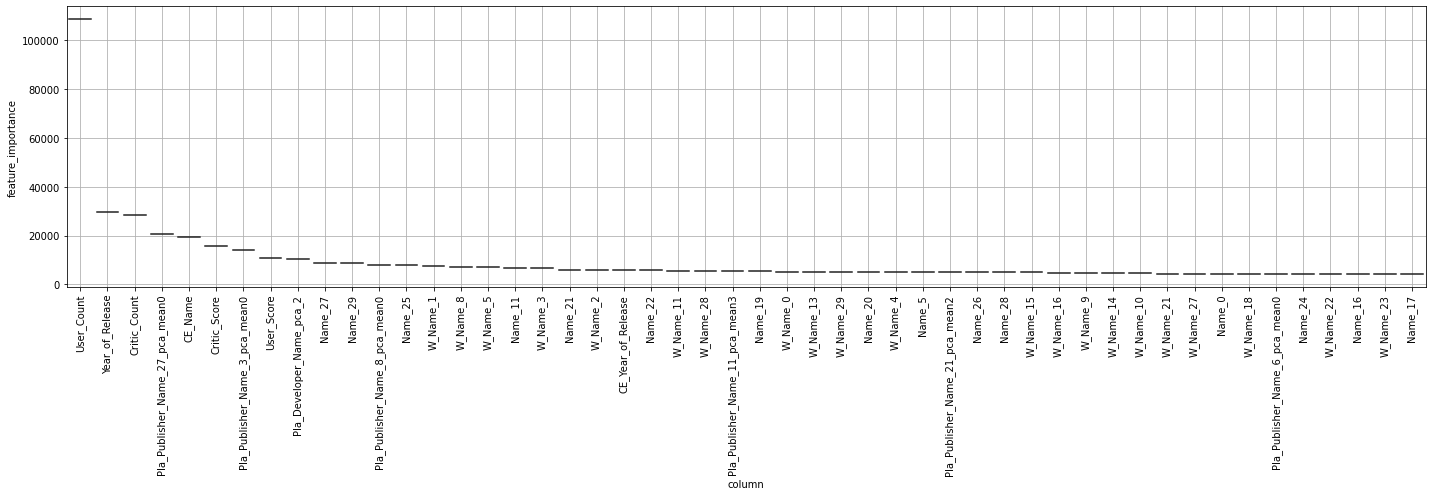

In [50]:
fig, ax = visualize_importance(model, X)


In [51]:
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=train_df_drop.columns, columns=['importance'])
importance.sort_values(['importance'])

,importance
Rat_Publisher_Name_13_pca_mean2,0.000000
Rat_Publisher_Name_18_pca_mean4,0.000000
Rat_Publisher_Name_18_pca_mean3,0.000000
Rat_Publisher_Name_18_pca_mean2,0.000000
Rat_Publisher_Name_18_pca_mean1,0.000000
...,...
CE_Name,19217.971248
Pla_Publisher_Name_27_pca_mean0,20641.495415
Critic_Count,28368.142341
Year_of_Release,29658.204146


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



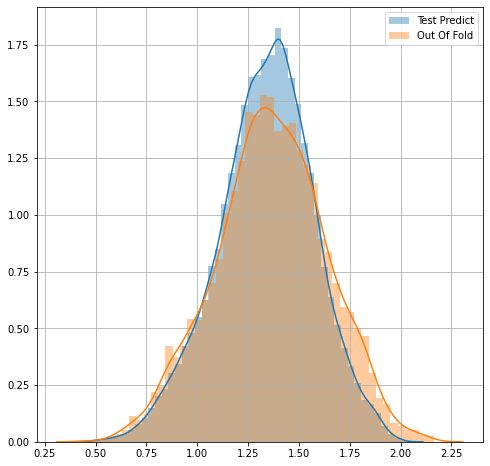

In [52]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(pred_test_np), label='Test Predict')
sns.distplot(np.log1p(oof_pred), label='Out Of Fold')
ax.legend()
ax.grid()

<AxesSubplot:>

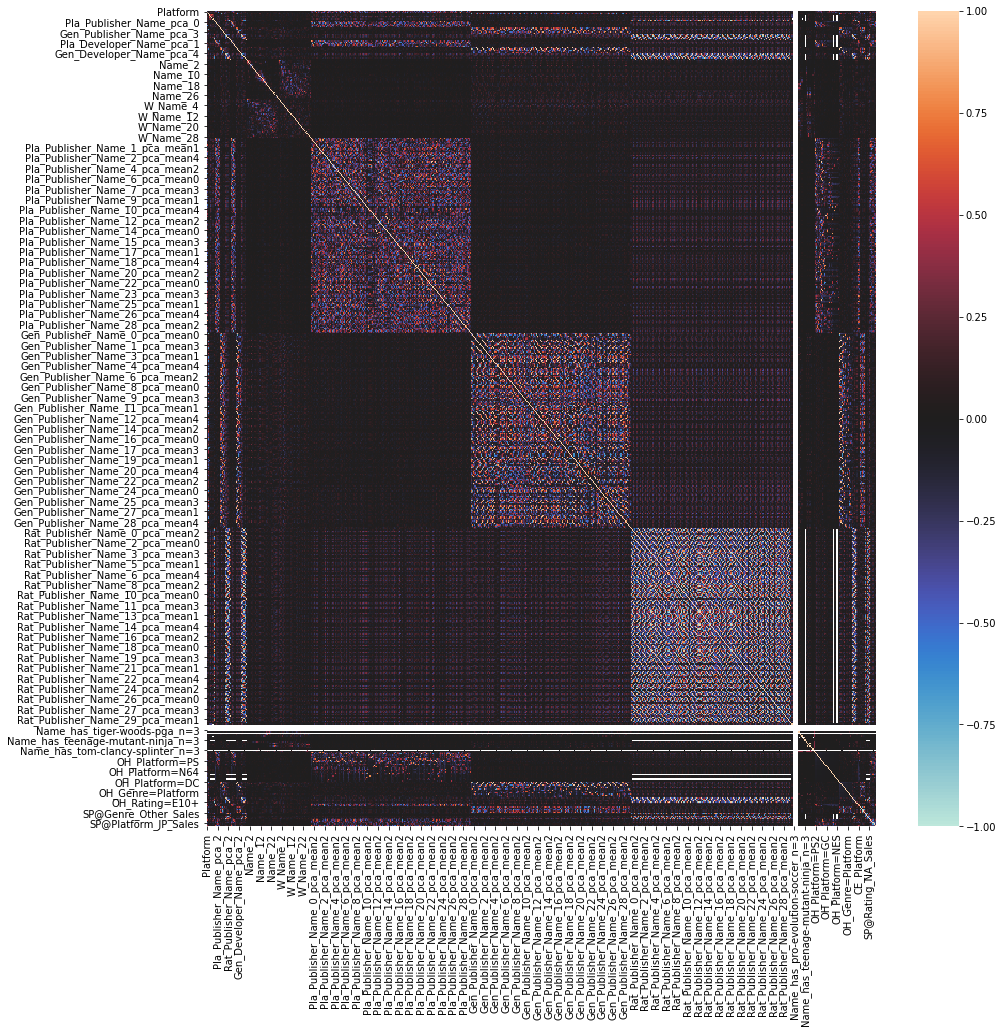

In [53]:
plt.figure(figsize=(15,15))
sns.heatmap(train_df_drop.corr(), vmax=1, vmin=-1, center=0)
# train_df_drop.corr().style.background_gradient(axis=None)

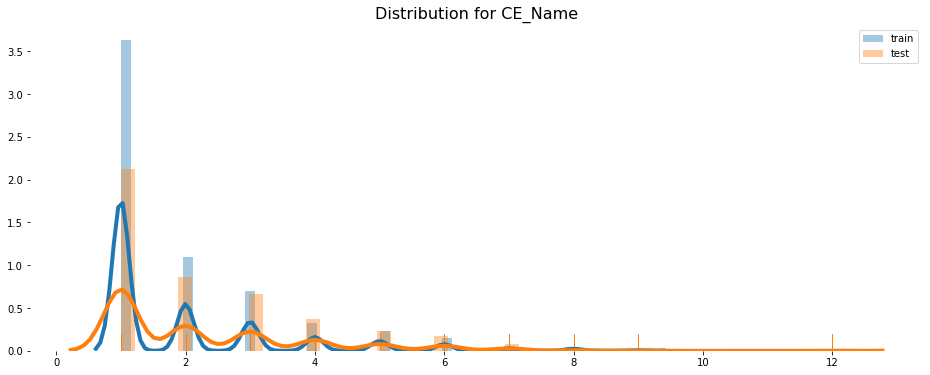

In [57]:
cols = 'CE_Name'
fig, ax = plt.subplots(figsize = (16, 6))

sns.distplot(train_df_drop[cols].values, 
             hist=True, rug=True, label='train',kde_kws=dict(linewidth=4))
sns.distplot(test_df[cols].values, 
             hist=True, rug=True, label='test', kde_kws=dict(linewidth=4))
ax.set_title(f'Distribution for {cols}', fontsize=16)
sns.despine(left=True, bottom=True)
plt.legend()
plt.show()